In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
from convokit import Corpus, download

In [4]:
corpus = Corpus(filename=download('reddit-corpus-small', use_local=True))

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-corpus-small


In [5]:
corpus = corpus.reindex_conversations([utt.id for utt in corpus.iter_utterances() if utt.id == utt.meta['top_level_comment']])

In [6]:
from convokit import ThreadDetails, ThreadDynamics

In [7]:
tdetails = ThreadDetails()

In [8]:
tdetails.transform(corpus)

In [10]:
tdynamics = ThreadDynamics()

In [11]:
tdynamics.transform(corpus)

In [12]:
convo = next(corpus.iter_conversations())

In [13]:
convo.print_conversation_structure(lambda utt: utt.user.id)

Mavamaarten
    Natanael_L
        frankiology
            EvaderDX
    cowjenga
    mphreak
        soapinmouth
            GreatBallsForHire
                sk1nnyjeans
        Mavamaarten
            swaded805
                nauticalsandwich
                    swaded805
    soapinmouth
        Larkman
            Realtrain
                bunnyofthekungfu
                    FlixbusLennart
    Fadic4
        xxfay6
        madminifi
        nauticalsandwich
    yatlvcar
        nauticalsandwich
            freshme4t
                t-to4st
                    freshme4t
                        l0rdc0rx
                            Cr4zyCr4ck3r
                                Jasonrj
                        t-to4st
                        nauticalsandwich
                    lemonpeazy11
                [deleted]
                    freshme4t
                    jclim00
                        [deleted]
                rarebit13
                [deleted]
                    freshme4t

In [25]:
feat_keys = sorted(convo.meta['thread_dynamics'], reverse=True)

In [21]:
import pandas as pd

In [36]:
data = []
convo_ids = []

In [37]:
for convo in corpus.iter_conversations():
    data.append([convo.meta['thread_dynamics'][k] for k in feat_keys])
    convo_ids.append(convo.id)

In [61]:
feats_df = pd.DataFrame(data, index=convo_ids, columns=feat_keys)

In [62]:
feats_df

,unique_users,C_targets_A,C_depth,C_chrono,B_depth,B_chrono,B2A_beforeC,B2A_afterC,A2B_beforeC,A2B_afterC
e6o3z6c,8,1,1,3,1,2,0,0,1,0
e6tnwvf,5,1,1,3,1,2,0,0,1,0
e5kr8w2,10,0,2,3,1,2,0,0,1,0
e6rxvzr,9,0,2,3,1,2,0,0,1,0
e5bsfra,9,1,1,3,1,2,0,0,1,0
e5euds7,8,1,1,3,1,2,0,0,1,0
e5uoxbf,5,1,1,4,1,2,1,0,1,0
e5apr51,5,0,2,3,1,2,0,0,1,0
e5l51ij,4,1,1,8,1,2,3,0,3,0
e5w276y,7,0,2,3,1,2,0,0,1,0


## Visualization

In [81]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [82]:
feat_mtx = Imputer(axis=1, missing_values=-1).fit_transform(feats_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [83]:
subreddits = [convo.meta['original_convo_meta']['subreddit'] for convo in corpus.iter_conversations()]

In [84]:
svd = TruncatedSVD(n_components=7, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [85]:
feats_df.shape

(10000, 10)

In [86]:
U_norm.shape

(10000, 3)

In [87]:
V_norm.shape

(10, 3)

In [88]:
feats_df.index

Index(['e6o3z6c', 'e6tnwvf', 'e5kr8w2', 'e6rxvzr', 'e5bsfra', 'e5euds7',
       'e5uoxbf', 'e5apr51', 'e5l51ij', 'e5w276y',
       ...
       'e5z8pfz', 'e5y1zd7', 'e6peiiy', 'e5jk8ka', 'e67h8un', 'e5yj9ux',
       'e6vdg91', 'e5fla2g', 'e6qacgh', 'e5yktq7'],
      dtype='object', length=10000)

In [89]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feats_df.index)
V_df = pd.DataFrame(data=V_norm, index=feat_keys)

In [90]:
U_df.head()

,0,1,2,3,4,5,6
e6o3z6c,-0.365196,-0.524785,0.321730,-0.436762,-0.422886,-0.092705,-0.330960
e6tnwvf,-0.135663,-0.289551,0.158150,-0.566702,0.646094,0.116284,-0.347323
e5kr8w2,-0.321360,-0.000514,-0.025288,0.719268,-0.516097,-0.043403,0.332418
e6rxvzr,-0.353157,0.023199,-0.051378,0.791576,-0.332585,0.003863,0.367261
e5bsfra,-0.335269,-0.445834,0.280686,-0.247287,-0.693428,-0.142380,-0.218580


In [91]:
U_df['subreddit'] = subreddits

In [92]:
subreddit_means = U_df.groupby('subreddit').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

In [93]:
tsne = TSNE(random_state=2018)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

In [94]:
import matplotlib.pyplot as plt

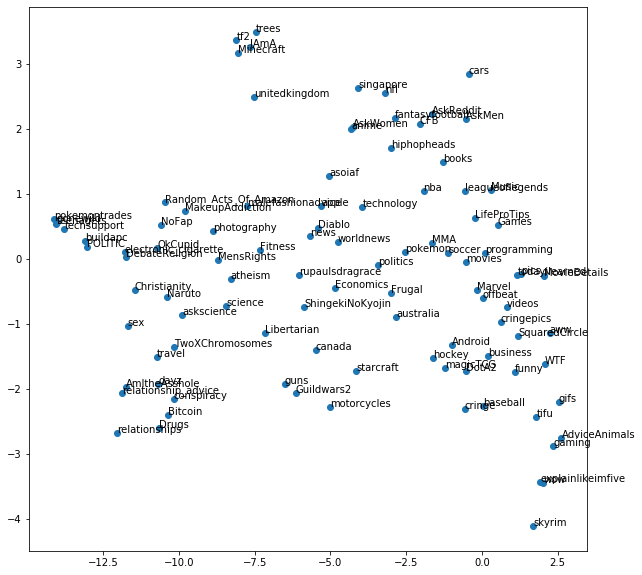

In [95]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

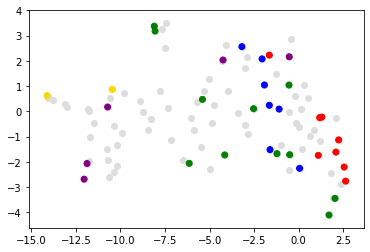

In [96]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "magicTCG", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
trade = ["Dota2Trade", "pokemontrades", "SteamGameSwap", "tf2trade", "Random_Acts_Of_Amazon"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]

link_aggregators = ["AskReddit", "WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = ["AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]

plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in trade else
    "purple" if l in relationships else
    "red" if l in link_aggregators else
    "blue" if l in sports else
    "#00000000"
    for l in tsne_df.index])
plt.show()